In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("creditcard_2023.csv")


# Features / Target


In [4]:
X = df.drop(["Class", "id"], axis=1)
y = df["Class"]


# Train/Test Split


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Scaling


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#  Hyperparameter Tuning


In [7]:
params = {
    "n_estimators": [100, 200],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1],
}


In [8]:
model = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=1  # dataset équilibré donc = 1
)



In [ ]:
grid = GridSearchCV(
    estimator=model,
    param_grid=params,
    cv=3,#cross validation
    scoring="f1",
    verbose=1,
    n_jobs=-1#utiliser tous les coeurs du processeur    
)


In [10]:
grid.fit(X_train_scaled, y_train)

print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}


#  Evaluation


In [11]:
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))




Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

ROC-AUC: 0.9999833283889467


### Le dataset utilisé est équilibré artificiellement → ce qui améliore la performance du modèle

# Confusion Matrix


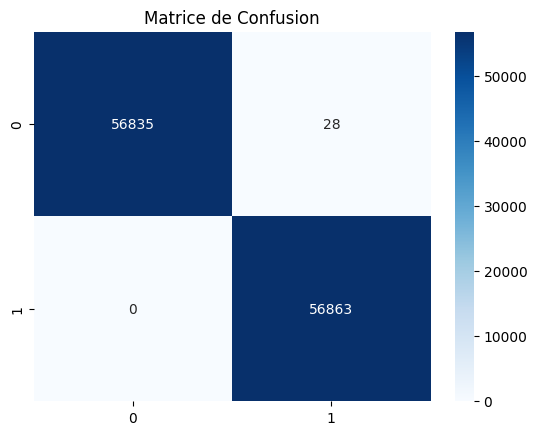

In [12]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.show()



## visualisation des features importantes

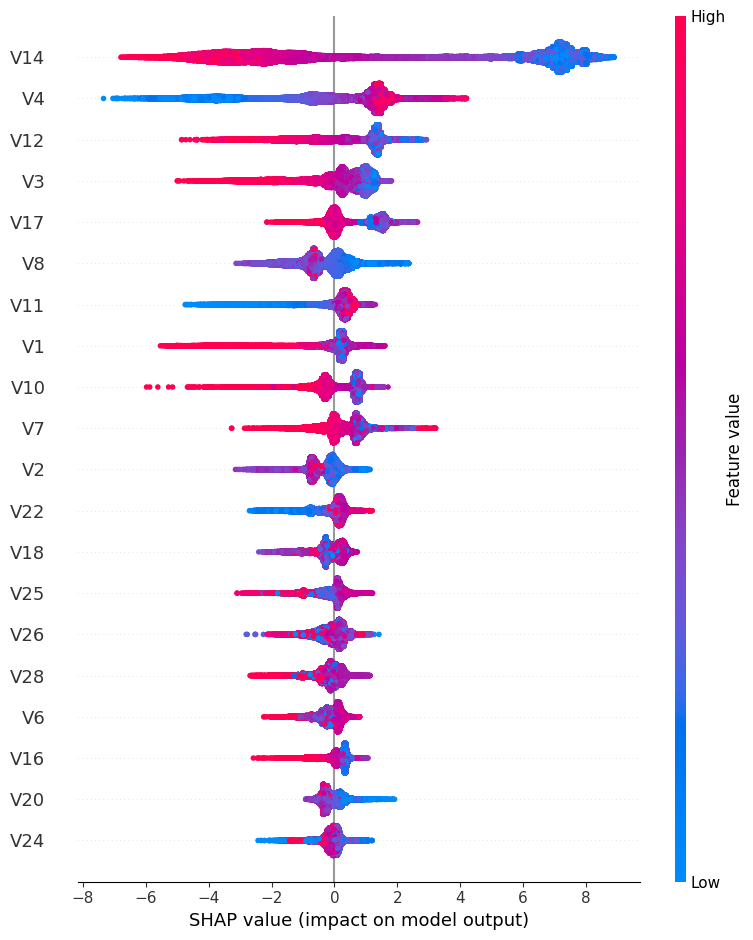

In [14]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot - importance des features
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


#  Export predictions for Power BI


In [25]:
test_results = X_test.copy()
test_results["proba_fraud"] = y_proba
test_results["real_class"] = y_test
test_results["predicted_class"] = y_pred

test_results.to_csv("fraud_predictions_powerbi.csv", index=False)
print("CSV exporté !")


CSV exporté !
